# PID Tuning

#### Manual Tuning,  Ziegler-Nichols & Cohen-Coon.

In this notebook we will define a PID controller with Set Points 0, 20 & 10.

We will solve with the classical PID Controller equation:

$$
u(t) = OP_0 + K_C e(t) + \frac{K_c}{\tau_I} \int_{0}^{t} e(\tau)d\tau + K_C \tau_D \frac{de(t)}{dt}
$$

For simplicity, as shown in the lecture, we will denote $ K_I = \frac{K_c}{\tau_I} $ and $  K_D = K_C \tau_D $, which will result in the following equation: 

$$
u(t) = OP_0 + K_C e(t) + K_I \int_{0}^{t} e(\tau)d\tau + K_D \frac{de(t)}{dt}
$$

Afterwards, we will use Ziegler-Nichols tuning rules and Cohen–Coon tuning rule.

In [1]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt
# For Jupyter Notebook
%matplotlib inline   

# Define wrapper functions to be used throught the entire notebook.
def getModel(Kc, Ki, Kd):
    """ 
    Define gekko model with given arguments as gains. 
        Ki = Kc/tauI
        Kd = Kc*tauD
    """
    model = GEKKO()        # Define Gekko model    

    tf = 40                # Time Final = 40 seconds.
    interval = 2 * tf + 1  # Results in 0.5 second intervals.

    # Set Points
    steps = np.zeros(interval)
    steps[3:20] = 20.0
    steps[20:]  = 10.0
    model.time = np.linspace(0, tf, interval)  # Set gekko model time space.
    
    # PID Controller model. Set new members for convenience.
    model.OP0 = model.Const(value=0)   # Controller output bias. 
    model.OP  = model.Var(value=0.0)   # Controller output.
    model.PV  = model.Var(value=0.0)   # Process variable.
    model.SP  = model.Param(value=steps)  # Set Points.
    
    # Define the error integral
    integral = model.Var(value = 0.0)
    err = model.Intermediate(model.SP - model.PV)    # Calculate error every solver's iteration.

    # Set the PID controller equation as was presented in the lecture.
    model.Equation(integral.dt() == err) # Set error integral equation.
    model.Equation(model.OP == model.OP0 + Kc*err + Ki*integral - Kd*model.PV.dt()) 
        
    # Process model
    Kp   = 0.5  # Process gain.
    tauP = 1.0  # Process time constant
    model.Equation(tauP * model.PV.dt() + model.PV == Kp * model.OP)
    model.options.IMODE = 4  # Simulation mode
    model.solve(disp=False)
    return model


def plotSolution(model):
    """ Plot the solution """
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(model.time, model.SP.value, 'k-', label='SP')
    plt.plot(model.time, model.PV.value,'r--',label='PV')
    plt.xlabel('Time (sec)')
    plt.ylabel('Process')
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(model.time, model.OP.value,'b:',label='OP')
    plt.ylabel('Output')
    plt.legend()
    plt.show()

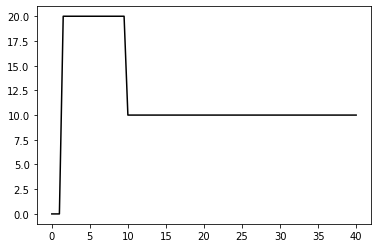

In [2]:
model = getModel(15, 2, 1)  # Define model with the gains introduced in the lecture.

# Plot Set Points graph as required.
plt.plot(model.time, model.SP.value, 'k-', label='SP')
plt.show()

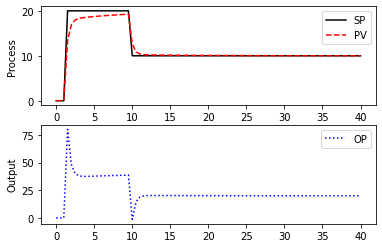

In [3]:
# Plot the solution
plotSolution(model)

In order to overcome the steady-state error received above, we will have to increase the integral gain $ K_I $.

So i've chose $ K_I = 20 $ which resulted in the following model:

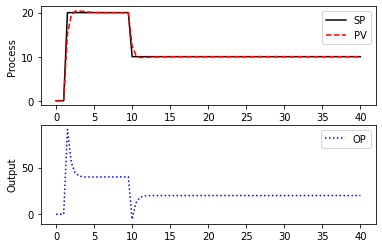

In [4]:
model = getModel(15, 20, 1)
plotSolution(model)

To make a bit better model, i've increased $ K_c = 30 $ which resulted in:

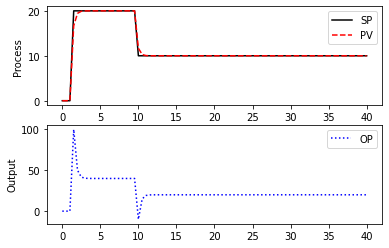

In [5]:
model = getModel(30, 20, 1)
plotSolution(model)

Trying to increase or descrease $ \tau_D $ was not helpfull. Hence we leave it intact.

### Tuning rules usage

Next, I will demonstrate the use of Ziegler-Nichols Oscillation Based Tuning Rules.

With the first Ziegler-Nichols method we set the controller to proportional mode without integrator and derivative action.
However, I couldn't find an appropriate $ K_c $ which cause oscillation. Hence, I will demonstrate the use of the second Ziegler-Nichols tuning rule.

In the following example, we set a small gain $ K_c = 1 $ which dosn't cause oscillation. 

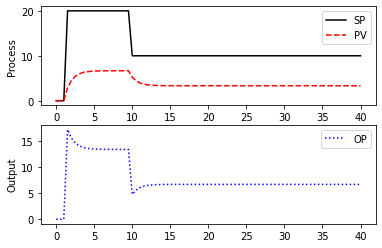

In [6]:
model = getModel(1, 0, 0)  # set P only model, with Kc = 1.
plotSolution(model)

Also, for a fairly large $ K_c = 100 $ we also see that oscillation is not achieved. 

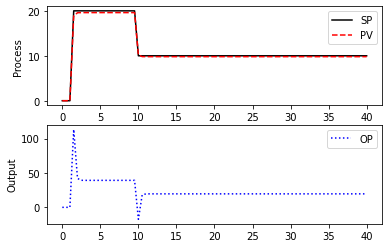

In [7]:
model = getModel(100, 0, 0)  # set P only model, with Kc = 100.
plotSolution(model)

The second Ziegler-Nichols tuning rule is based on the First Order Plus Delay model. 

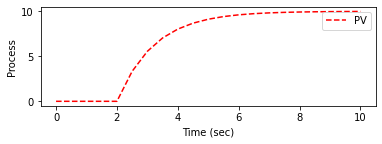

In [8]:
model     = GEKKO()
tf        = 10
interval  = 2 * tf + 1
steps     = np.zeros(interval)
steps[5:] = 20

SP = model.Param(value=steps)

PV = model.Var(value = 0.0)    # process variable
model.time = np.linspace(0, tf, interval)  # Set gekko model time space.

Kproc = 0.5 # Process gain.
tauP  = 1.0 # Process time constant
x = model.Param(value=steps)  # add step function behaviour.
model.Equation( tauP * PV.dt() + PV == Kproc * x)
model.options.IMODE = 4  # Simulation mode
model.solve(disp=False)

# Plot the Plant
plt.figure()
plt.subplot(2,1,1)
plt.plot(model.time, PV.value,'r--',label='PV')
plt.xlabel('Time (sec)')
plt.ylabel('Process')
plt.legend()
plt.show()

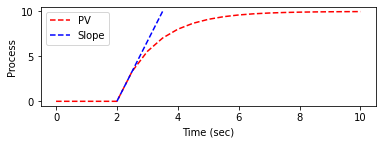

In [9]:
# Approximating the Slope
plt.figure()
plt.subplot(2,1,1)
plt.plot(model.time, PV.value,'r--',label='PV')
plt.plot([2, 3.5], [0, 10],'b--',label='Slope')
plt.xlabel('Time (sec)')
plt.ylabel('Process')
plt.legend()
plt.show()

In [10]:
# Approximating the parameters according to the plot above.
Kss = (10 - 0) / (3.5 - 2)
tauM = 3.5 - 2
d = 2 - 1.95 # Assume a small delay in the system.

### Ziegler-Nichols second method

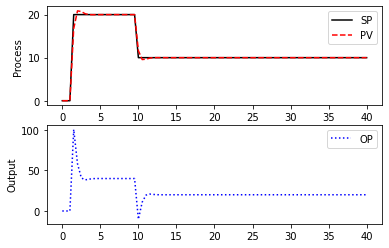

In [11]:
# Calculate Ziegler-Nichols parameters.
Kp = (1.2 * tauM) / (Kss * d)
Ki = Kp / (2 * d)
Kd = Kp * (0.5 * d)

# Solve & Plot the model
model = getModel(Kp, Ki, Kd)
plotSolution(model)

### Cohen-Coon method

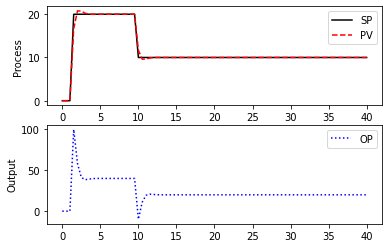

In [12]:
# Calculate Cohen-Coon parameters.
Kp = (tauM / (Kss * d)) * ( (4 / 3) + (d / (4 * tauM)))
Ki = Kp / ( (d * (32 * tauM + 6 * d)) / (13 * tauM + 8 * d) )
Kd = Kp * ((4 * d * tauM) / (11 * tauM + 2 * d))

# Solve & Plot the model
model= getModel(Kp, Ki, Kd)
plotSolution(model)

Both with Ziegler-Nichols second method and with Cohen-Coon method we've received a fairly good results.